# Sections
* [Introduction](#0)
* [1. Setup](#1)
* [2. Data Import](#2)  
* [3. Data Overview and Cleaning](#3)
    * [3.1. Brief Overview of how the dataset we used for later analysis looks like](#3.1)
    * [3.2. Idenfify date range, number of distinct users, and other ranges](#3.2)
    * [3.3. Data cleaning for Missing Values or invalid entry](#3.3)
* [4. Data Analysis and Visualization](#4)
    * [4.1. Active users per day](#4.1)
    * [4.2. We want to understand if there is relationship between calorie burned and total steps](#4.2)
    * [4.3. A bar chart that shows calorie and step total for each day of week](#4.3)
    * [4.4. Would the percentage of very active distance impact distance per step?](#4.4)
    * [4.5. Pie chart to show percetage of activity intensity](#4.5)
    * [4.6. Average very active Distance per very active minute for each user](#4.6)
    * [4.7. Scatter plot Calories vs Time Slept](#4.7)
    * [4.8. We want to analyze the correlation between hearrate, calories spending, intensitries, and steps](#4.8)
* [5. Conclustion and Recommendation](#5)
    * [5.1. Conclusion from Data Overview](#5.1)
    * [5.2. Conclusion from Data Analysis](#5.2)
    * [5.3. Recommendation](#5.3)

<a id='0'></a>
## Introduction of the project

To better understand customer behavior through analyzing their activity during the day, calorie spending, total number of steps, or heartrate, etc

<a id='1'></a>
## 1. Setup

In [1]:
import findspark
findspark.init()
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
from pyspark.sql.session import SparkSession

spark = SparkSession.builder\
                    .appName("Group_Project")\
                    .getOrCreate()

print(f"This cluster relies on Spark '{spark.version}'")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


This cluster relies on Spark '3.2.1'


In [3]:
#Center the plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell; 
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<a id='2'></a>
## 2. Data Import

In [4]:
#Package Imports
from pyspark.sql.types import DoubleType, IntegerType,TimestampType
from pyspark.sql.functions import col, corr
from pyspark.sql.functions import input_file_name
from pyspark.sql.functions import min, max
from pyspark.sql.functions import avg,to_date,substring,count,split,concat_ws
import matplotlib.pyplot as plt
from pyspark.sql.functions import sum
from pyspark.sql.functions import length,concat,lit,to_timestamp,date_add,length,split,when
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [5]:
# DataFrame creation
FitaBasedailyActivity_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/dailyActivity_merged",header=True)
FitaBasedailyCalories_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/dailyCalories_merged",header=True)
FitaBasedailyIntensities_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/dailyIntensities_merged",header=True)
FitaBasedailySteps_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/dailySteps_merged",header=True)
FitaBaseheartrate_seconds_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/heartrate_seconds_merged",header=True)
FitaBasehourlyCalories_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/hourlyCalories_merged",header=True)
FitaBasehourlyIntensities_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/hourlyIntensities_merged",header=True)
FitaBasehourlySteps_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/hourlySteps_merged",header=True)
FitaBaseminuteCaloriesNarrow_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteCaloriesNarrow_merged",header=True)
FitaBaseminuteCaloriesWide_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteCaloriesWide_merged",header=True)
FitaBaseminuteIntensitiesNarrow_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteIntensitiesNarrow_merged",header=True)
FitaBaseminuteIntensitiesWide_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteIntensitiesWide_merged",header=True)
FitaBaseminuteMETsNarrow_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteMETsNarrow_merged",header=True)
FitaBaseminuteSleep_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteSleep_merged",header=True)
FitaBaseminuteStepsNarrow_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteStepsNarrow_merged",header=True)
FitaBaseminuteStepsWide_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/minuteStepsWide_merged",header=True)
FitaBasesleepDay_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/sleepDay_merged",header=True)
FitaBaseweightLogInfo_mergedRaw = spark.read.csv("hdfs://localhost:9000/datalake/raw/weightLogInfo_merged",header=True)

<a id='3'></a>
## 3. Data Overview and Cleaning

<a id='3.1'></a>
#3.1 Brief Overview of how the dataset we used for later analysis looks like

In [6]:
FitaBasedailyActivity_mergedRaw.limit(10).toPandas()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.5,8.5,0,1.87999999523163,0.550000011920929,6.05999994277954,0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.96999979019165,6.96999979019165,0,1.57000005245209,0.689999997615814,4.71000003814697,0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.73999977111816,6.73999977111816,0,2.44000005722046,0.400000005960464,3.91000008583069,0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28000020980835,6.28000020980835,0,2.14000010490417,1.25999999046326,2.82999992370605,0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.15999984741211,8.15999984741211,0,2.71000003814697,0.409999996423721,5.03999996185303,0,36,10,221,773,1863
5,1503960366,4/17/2016,9705,6.48000001907349,6.48000001907349,0,3.19000005722046,0.779999971389771,2.50999999046326,0,38,20,164,539,1728
6,1503960366,4/18/2016,13019,8.59000015258789,8.59000015258789,0,3.25,0.639999985694885,4.71000003814697,0,42,16,233,1149,1921
7,1503960366,4/19/2016,15506,9.88000011444092,9.88000011444092,0,3.52999997138977,1.32000005245209,5.03000020980835,0,50,31,264,775,2035
8,1503960366,4/20/2016,10544,6.67999982833862,6.67999982833862,0,1.96000003814697,0.479999989271164,4.23999977111816,0,28,12,205,818,1786
9,1503960366,4/21/2016,9819,6.34000015258789,6.34000015258789,0,1.3400000333786,0.349999994039536,4.65000009536743,0,19,8,211,838,1775


In [7]:
FitaBaseheartrate_seconds_mergedRaw.limit(10).show()

+----------+--------------------+-----+
|        Id|                Time|Value|
+----------+--------------------+-----+
|2022484408|4/12/2016 7:21:00 AM|   97|
|2022484408|4/12/2016 7:21:05 AM|  102|
|2022484408|4/12/2016 7:21:10 AM|  105|
|2022484408|4/12/2016 7:21:20 AM|  103|
|2022484408|4/12/2016 7:21:25 AM|  101|
|2022484408|4/12/2016 7:22:05 AM|   95|
|2022484408|4/12/2016 7:22:10 AM|   91|
|2022484408|4/12/2016 7:22:15 AM|   93|
|2022484408|4/12/2016 7:22:20 AM|   94|
|2022484408|4/12/2016 7:22:25 AM|   93|
+----------+--------------------+-----+



In [8]:
FitaBasesleepDay_mergedRaw.limit(10).toPandas()

,Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,4/12/2016 12:00:00 AM,1,327,346
1,1503960366,4/13/2016 12:00:00 AM,2,384,407
2,1503960366,4/15/2016 12:00:00 AM,1,412,442
3,1503960366,4/16/2016 12:00:00 AM,2,340,367
4,1503960366,4/17/2016 12:00:00 AM,1,700,712
5,1503960366,4/19/2016 12:00:00 AM,1,304,320
6,1503960366,4/20/2016 12:00:00 AM,1,360,377
7,1503960366,4/21/2016 12:00:00 AM,1,325,364
8,1503960366,4/23/2016 12:00:00 AM,1,361,384
9,1503960366,4/24/2016 12:00:00 AM,1,430,449


In [9]:
#The following files will also be used for this analysis

#FitaBasehourlyCalories_mergedRaw
#FitaBasehourlyIntensities_mergedRaw
#FitaBasehourlySteps_mergedRaw


<a id='3.2'></a>
#3.2 Idenfify date range, number of distinct users, and other ranges

In [10]:
#3.2.1 Identify the date range
FitaBasedailyActivity_mergedRaw.describe(['ActivityDate']).show()

+-------+------------+
|summary|ActivityDate|
+-------+------------+
|  count|         940|
|   mean|        null|
| stddev|        null|
|    min|   4/12/2016|
|    max|    5/9/2016|
+-------+------------+



In [11]:
#3.2.2 Identify number of user
FitaBasesleepDay_mergedRaw.select('Id').distinct().count()

24

In [12]:
#3.2.3 average, min, and max heartrate per user for any recorded data
FitaBaseheartrate_seconds_mergedRaw\
    .withColumn('Value',col('Value').cast(DoubleType()))\
    .groupBy('Id').agg(avg('Value'),min('Value'),max('Value'))\
    .toPandas().to_csv('3_2_3_average_min_max_hearrate.csv')

In [13]:
#3.2.4 average, min, and max sleep minutes per user for any recorded data
FitaBasesleepDay_mergedRaw\
    .withColumn('TotalMinutesAsleep',col('TotalMinutesAsleep').cast(IntegerType()))\
    .groupBy('Id').agg(avg('TotalMinutesAsleep').alias('AvgTotalMinutesAsleep'),min('TotalMinutesAsleep'),max('TotalMinutesAsleep'),count('TotalMinutesAsleep'))\
    .sort(col('AvgTotalMinutesAsleep'))\
    .toPandas().to_csv('3_2_4_average_min_max_sleep.csv')

In [14]:
#3.2.5 average, min, and max sleep minutes per user for any recorded data
FitaBasedailyActivity_mergedRaw\
    .withColumn('TotalSteps',col('TotalSteps').cast(IntegerType()))\
    .withColumn('TotalDistance',col('TotalDistance').cast(DoubleType()))\
    .groupBy('Id').agg(avg('TotalSteps'),min('TotalSteps'),max('TotalSteps'),count('TotalSteps'),\
                       avg('TotalDistance'),min('TotalDistance'),max('TotalDistance'),count('TotalDistance')
                        )\
    .toPandas().to_csv('3_2_5_average_min_max_steps.csv')

<a id='3.3'></a>
#3.3 Data cleaning for Missing Values or invalid entry

#From 3.2.4, we see users 2320127002, 7007744171, 4558609924 have average sleep minutes 61, 68.5, and 127.6 minutes respectively The count of each is 1, 2,and 5. In this case, since the average sleep minutes does not make sense in the real, we choose to remove these users and consider the data as invalid.

In [15]:
FitaBasesleepDay_mergedRaw\
    = FitaBasesleepDay_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')")

In [16]:
FitaBasedailyActivity_mergedRaw\
    = FitaBasedailyActivity_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')")

In [17]:
FitaBasesleepDay_mergedRaw.describe(['Id']).show()

+-------+--------------------+
|summary|                  Id|
+-------+--------------------+
|  count|                 405|
|   mean| 5.003150193982716E9|
| stddev|2.0709883595079844E9|
|    min|          1503960366|
|    max|          8792009665|
+-------+--------------------+



In [18]:
FitaBasesleepDay_mergedRaw.dropna().describe(['Id']).show()

+-------+--------------------+
|summary|                  Id|
+-------+--------------------+
|  count|                 405|
|   mean| 5.003150193982716E9|
| stddev|2.0709883595079844E9|
|    min|          1503960366|
|    max|          8792009665|
+-------+--------------------+



In [19]:
FitaBasedailyActivity_mergedRaw.describe(['Id']).show()

+-------+-------------------+
|summary|                 Id|
+-------+-------------------+
|  count|                852|
|   mean|4.892770814578638E9|
| stddev|2.471315442250915E9|
|    min|         1503960366|
|    max|         8877689391|
+-------+-------------------+



In [20]:
FitaBasedailyActivity_mergedRaw.dropna().describe(['Id']).show()

+-------+-------------------+
|summary|                 Id|
+-------+-------------------+
|  count|                852|
|   mean|4.892770814578638E9|
| stddev|2.471315442250915E9|
|    min|         1503960366|
|    max|         8877689391|
+-------+-------------------+



In [21]:
FitaBaseheartrate_seconds_mergedRaw.describe(['Id']).show()

+-------+--------------------+
|summary|                  Id|
+-------+--------------------+
|  count|             2483658|
|   mean| 5.513764629269958E9|
| stddev|1.9502237609635031E9|
|    min|          2022484408|
|    max|          8877689391|
+-------+--------------------+



In [22]:
FitaBaseheartrate_seconds_mergedRaw.dropna().describe(['Id']).show()

+-------+--------------------+
|summary|                  Id|
+-------+--------------------+
|  count|             2483658|
|   mean| 5.513764629269958E9|
| stddev|1.9502237609635031E9|
|    min|          2022484408|
|    max|          8877689391|
+-------+--------------------+



<a id='4'></a>
## 4. Data Analysis and Visualization

4.1 - 4.3 is only to show we are able to convert Spark to Pandas and do further analysis, starting from 4.4, we will only use Pandas to draw the graph

<a id='4.1'></a>
#4.1 Active users per day 

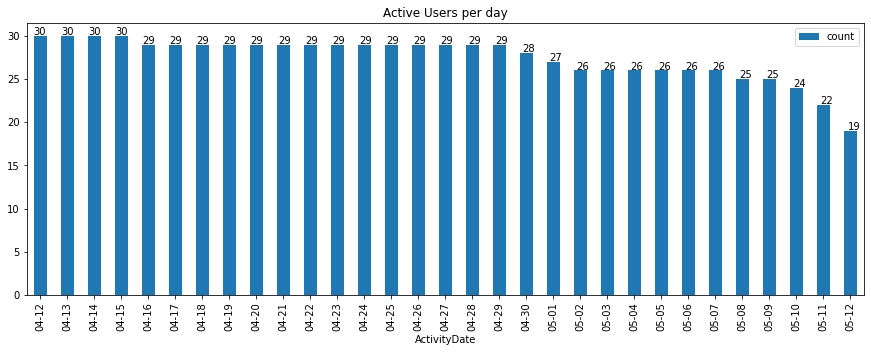

In [23]:

plt.rcParams['figure.figsize'] = [15, 5]
df = FitaBasedailyActivity_mergedRaw.select('ID','ActivityDate').toPandas()
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'], format='%m/%d/%Y').dt.strftime('%m-%d')
df_hist = df.groupby(['ActivityDate'])['ID'].count().reset_index(name="count")

ax = df_hist.plot(x='ActivityDate',y='count',kind='bar',title='Active Users per day')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

<a id='4.2'></a>
#4.2 We want to understand if there is relationship between calorie burned and total steps

In [24]:
df_cal_step = FitaBasedailyCalories_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')").join(FitaBasedailySteps_mergedRaw,['ID','ActivityDay']).toPandas()

In [25]:
df_cal_step.head()
df_cal_step["Calories"] = pd.to_numeric(df_cal_step["Calories"])
df_cal_step["StepTotal"] = pd.to_numeric(df_cal_step["StepTotal"])
df_cal_step.dtypes

Id             object
ActivityDay    object
Calories        int64
StepTotal       int64
dtype: object

In [47]:
df_cal_step.to_csv('4_2_forJorge.csv')

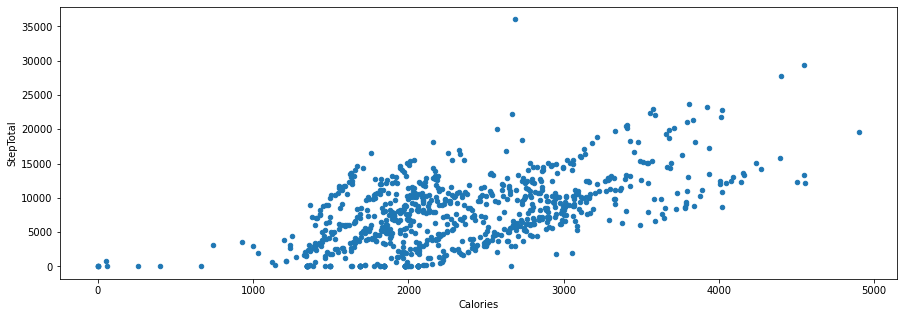

In [26]:
ax = df_cal_step.plot(x='Calories',y='StepTotal',kind='scatter')

In [27]:
df_cal_step.corr().to_csv('4_2_corr.csv')

<a id='4.3'></a>
#4.3 A bar chart that shows calorie and step total for each day of week

In [28]:
df_cal_step['ActivityDay'] = pd.to_datetime(df_cal_step['ActivityDay'], format='%m/%d/%Y')
df_cal_step['DayofWeek'] = df_cal_step['ActivityDay'].dt.day_name()
df_cal_step.head()

,Id,ActivityDay,Calories,StepTotal,DayofWeek
0,1503960366,2016-04-12,1985,13162,Tuesday
1,1503960366,2016-04-13,1797,10735,Wednesday
2,1503960366,2016-04-14,1776,10460,Thursday
3,1503960366,2016-04-15,1745,9762,Friday
4,1503960366,2016-04-16,1863,12669,Saturday


In [29]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
cal_step_avg = df_cal_step[['Calories','StepTotal','DayofWeek']].groupby('DayofWeek').mean().reindex(days).reset_index()
cal_step_avg['Calories'] = cal_step_avg['Calories'].round(2)
cal_step_avg['StepTotal'] = cal_step_avg['StepTotal'].round(2)
cal_step_avg.to_csv('4_3_DayofWeek.csv')

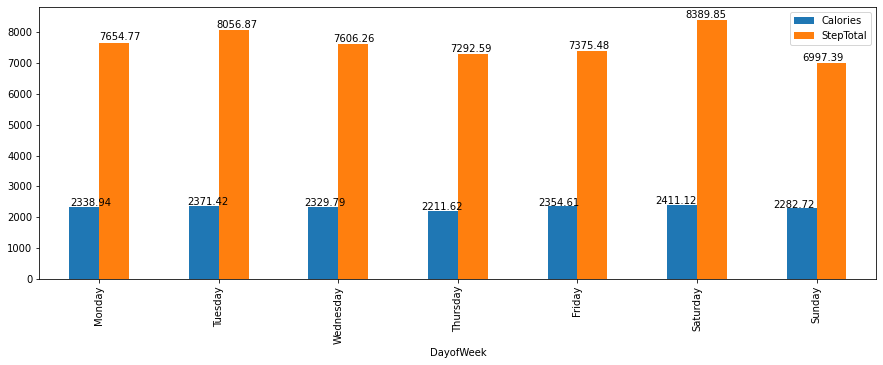

In [30]:
ax = cal_step_avg.plot(x='DayofWeek',y=['Calories','StepTotal'],kind='bar')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 0.98, p.get_height() * 1.01))

<a id='4.4'></a>
#4.4 Would the percentage of very active distance impact distance per step?

In [31]:
FitaBasedailyActivity_mergedRaw.select('TotalSteps','TotalDistance','VeryActiveDistance').toPandas().to_csv('4_4_percentageactive.csv')

In [32]:
fitadf = FitaBasedailyActivity_mergedRaw.select('TotalSteps','TotalDistance','VeryActiveDistance')\
    .withColumn('TotalSteps',col('TotalSteps').cast(IntegerType()))\
    .withColumn('TotalDistance',col('TotalDistance').cast(DoubleType()))\
    .withColumn('VeryActiveDistance',col('VeryActiveDistance').cast(DoubleType()))\
    .withColumn('DistancePerStep',col('TotalDistance')*1000/col('TotalSteps'))\
    .withColumn('VeryActiveDistanceRate',col('VeryActiveDistance')/col('TotalDistance'))\
    .select(corr(col('DistancePerStep'),col('VeryActiveDistanceRate')))\
    .toPandas().to_csv('4_4_corr.csv')

<a id='4.5'></a>
#4.5 Pie chart to show percetage of activity intensity

In [33]:

activeMinutes = FitaBasedailyActivity_mergedRaw\
    .withColumn('VeryActiveMinutes',col('VeryActiveMinutes').cast(IntegerType()))\
    .withColumn('FairlyActiveMinutes',col('FairlyActiveMinutes').cast(IntegerType()))\
    .withColumn('LightlyActiveMinutes',col('LightlyActiveMinutes').cast(IntegerType()))\
    .withColumn('SedentaryMinutes',col('SedentaryMinutes').cast(IntegerType()))\
    .select('VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes')

pie_chart_data = activeMinutes.select(avg('VeryActiveMinutes').alias('AverageVeryActiveMinutes'),\
                    avg('FairlyActiveMinutes').alias('AverageFairlyActiveMinutes'),\
                    avg('LightlyActiveMinutes').alias('AverageLightlyActiveMinutes'),\
                    avg('SedentaryMinutes').alias('AverageSedentaryMinutes'))\
    .toPandas().T

pie_chart_data.columns = ['Value']

In [34]:
pie_chart_data.to_csv('4_5_activity_intensity.csv')

<AxesSubplot:ylabel='Value'>

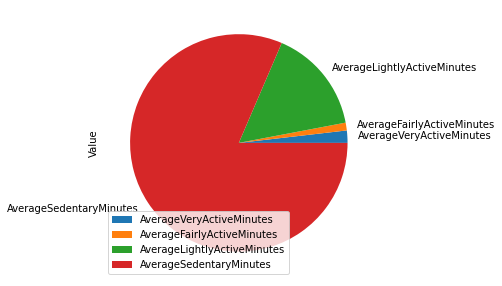

In [35]:
pie_chart_data.plot.pie(y='Value')

<a id='4.6'></a>
#4.6 Average very active Distance per very active minute for each user

In [36]:
activedf = FitaBasedailyActivity_mergedRaw.select('Id','ActivityDate','VeryActiveDistance','VeryActiveMinutes')\
    .withColumn('VeryActiveMinutes',col('VeryActiveMinutes').cast(IntegerType()))\
    .withColumn('VeryActiveDistance',col('VeryActiveDistance').cast(DoubleType()))\
    .groupBy('Id').agg(avg('VeryActiveMinutes').alias('AvgVeryActiveMinutes'),avg('VeryActiveDistance').alias('AvgVeryActiveDistance'))\
    .withColumn('VeryActiveDistanceMinutes',col('AvgVeryActiveDistance')/col('AvgVeryActiveMinutes'))\
    .sort(col('VeryActiveDistanceMinutes').desc())\
    .toPandas().to_csv('4_6_activemin.csv')

This shows that for each person, s/he travels 80 meters to 110 meters under a very active distance on average

<a id='4.7'></a>
#4.7 Scatter plot Calories vs Time Slept

In [37]:
cal_time_df = FitaBasesleepDay_mergedRaw\
    .select('Id','SleepDay','TotalMinutesAsleep','TotalTimeInBed')\
    .withColumn('Date',substring('SleepDay',1,9))\
    .join(FitaBasedailyCalories_mergedRaw.select('Id','ActivityDay','Calories')\
                  .withColumn('Date',substring('ActivityDay',1,9))\
              ,['Id','Date'])

cal_time_df.select(corr(col('TotalMinutesAsleep'),col('Calories'))).toPandas().to_csv('4_7_corr.csv')


In [50]:
cal_time_df.toPandas().to_csv('4_7_forJorge.csv')

<AxesSubplot:xlabel='TotalMinutesAsleep', ylabel='Calories'>

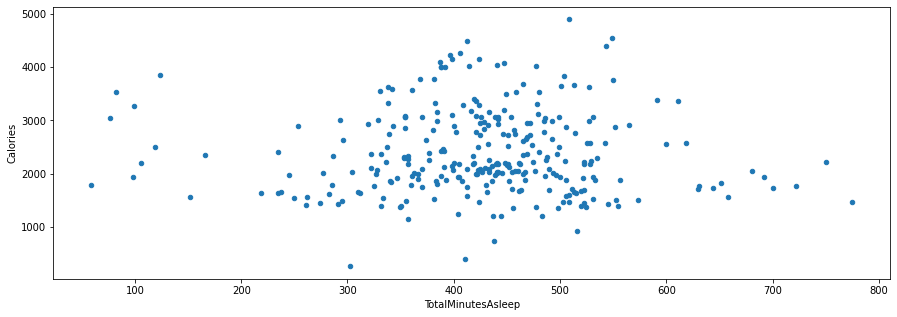

In [38]:
cal_time_df.select('TotalMinutesAsleep','Calories')\
    .withColumn('Calories',col('Calories').cast(DoubleType()))\
    .withColumn('TotalMinutesAsleep',col('TotalMinutesAsleep').cast(IntegerType()))\
    .toPandas().plot(x='TotalMinutesAsleep',y='Calories',kind='scatter')

<a id='4.8'></a>
#4.8 We want to analyze the correlation between heartrate, calories spending, intensitries, and steps

In [39]:
heart_rate = FitaBaseheartrate_seconds_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')")\
    .select('Id','Value',\
        split(split(col("Time")," ")[0],'/')[0].alias('Month'),\
        split(split(col("Time")," ")[0],'/')[1].alias('Day'),\
        split(split(col("Time")," ")[0],'/')[2].alias('Year'),\
        split(split(col("Time")," ")[1],':')[0].alias('Hour'))\
    .withColumn('DateSTR',\
                concat_ws(' ',\
                concat_ws("-",\
                          col('Year'),\
                          when(length(col('Month'))==1,concat(lit('0'),col('Month'))),\
                          when(length(col('Month'))==2,col('Month')),\
                          when(length(col('Day'))==1,concat(lit('0'),col('Day'))),\
                          when(length(col('Day'))==2,col('Day')),\
                         ),\
                          
                          when(length(col('Hour'))==1,concat(lit('0'),col('Hour'))),\
                          when(length(col('Hour'))==2,col('Hour'))\
                         )\
               )\
    .withColumn('Date',to_timestamp(col('DateSTR'),'yyyy-MM-dd HH'))\
    .withColumn('Value',col('Value').cast(IntegerType()))\
    .select('Id','Date','Value')\
    .groupBy('Id','Date').agg(avg('Value').alias('Heartrate'))



heart_rate.where(col('Date')=='2016-04-15 09:00:00').limit(10).show()

    #.withColumn('Hour',concat(lit('INTERVAL '),col('Hour'),lit(' HOURS')))\

+----------+-------------------+------------------+
|        Id|               Date|         Heartrate|
+----------+-------------------+------------------+
|2347167796|2016-04-15 09:00:00| 75.18808411214954|
|2022484408|2016-04-15 09:00:00|117.06666666666666|
|4020332650|2016-04-15 09:00:00|112.67044809982984|
|4388161847|2016-04-15 09:00:00| 67.36036036036036|
|5553957443|2016-04-15 09:00:00| 62.92727272727273|
|5577150313|2016-04-15 09:00:00| 65.41063084112149|
|6117666160|2016-04-15 09:00:00| 93.78365384615384|
|6775888955|2016-04-15 09:00:00| 79.51836734693877|
|6962181067|2016-04-15 09:00:00| 85.41133004926108|
|8792009665|2016-04-15 09:00:00|63.409893992932865|
+----------+-------------------+------------------+



In [40]:
hourly_calories = FitaBasehourlyCalories_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')")\
    .select('Id','Calories',\
        split(split(col("ActivityHour")," ")[0],'/')[0].alias('Month'),\
        split(split(col("ActivityHour")," ")[0],'/')[1].alias('Day'),\
        split(split(col("ActivityHour")," ")[0],'/')[2].alias('Year'),\
        split(split(col("ActivityHour")," ")[1],':')[0].alias('Hour'))\
    .withColumn('DateSTR',\
                concat_ws(' ',\
                concat_ws("-",\
                          col('Year'),\
                          when(length(col('Month'))==1,concat(lit('0'),col('Month'))),\
                          when(length(col('Month'))==2,col('Month')),\
                          when(length(col('Day'))==1,concat(lit('0'),col('Day'))),\
                          when(length(col('Day'))==2,col('Day')),\
                         ),\
                          
                          when(length(col('Hour'))==1,concat(lit('0'),col('Hour'))),\
                          when(length(col('Hour'))==2,col('Hour'))\
                         )\
               )\
    .withColumn('Date',to_timestamp(col('DateSTR'),'yyyy-MM-dd HH'))\
    .withColumn('Calories',col('Calories').cast(IntegerType()))\
    .select('Id','Date','Calories')\
    .groupBy('Id','Date').agg(avg('Calories').alias('Calories'))



hourly_calories.where(col('Id')=='2347167796').where(col('Date')=='2016-04-15 09:00:00').limit(10).show()

    #.withColumn('Hour',concat(lit('INTERVAL '),col('Hour'),lit(' HOURS')))\

+----------+-------------------+--------+
|        Id|               Date|Calories|
+----------+-------------------+--------+
|2347167796|2016-04-15 09:00:00|    88.5|
+----------+-------------------+--------+



In [41]:
hourly_intensities = FitaBasehourlyIntensities_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')")\
    .select('Id','TotalIntensity',\
        split(split(col("ActivityHour")," ")[0],'/')[0].alias('Month'),\
        split(split(col("ActivityHour")," ")[0],'/')[1].alias('Day'),\
        split(split(col("ActivityHour")," ")[0],'/')[2].alias('Year'),\
        split(split(col("ActivityHour")," ")[1],':')[0].alias('Hour'))\
    .withColumn('DateSTR',\
                concat_ws(' ',\
                concat_ws("-",\
                          col('Year'),\
                          when(length(col('Month'))==1,concat(lit('0'),col('Month'))),\
                          when(length(col('Month'))==2,col('Month')),\
                          when(length(col('Day'))==1,concat(lit('0'),col('Day'))),\
                          when(length(col('Day'))==2,col('Day')),\
                         ),\
                          
                          when(length(col('Hour'))==1,concat(lit('0'),col('Hour'))),\
                          when(length(col('Hour'))==2,col('Hour'))\
                         )\
               )\
    .withColumn('Date',to_timestamp(col('DateSTR'),'yyyy-MM-dd HH'))\
    .withColumn('TotalIntensity',col('TotalIntensity').cast(IntegerType()))\
    .select('Id','Date','TotalIntensity')\
    .groupBy('Id','Date').agg(avg('TotalIntensity').alias('Intensity'))


hourly_intensities.where(col('Id')=='2347167796').where(col('Date')=='2016-04-15 09:00:00').limit(10).show()

    #.withColumn('Hour',concat(lit('INTERVAL '),col('Hour'),lit(' HOURS')))\

+----------+-------------------+---------+
|        Id|               Date|Intensity|
+----------+-------------------+---------+
|2347167796|2016-04-15 09:00:00|     16.0|
+----------+-------------------+---------+



In [42]:
hourly_steps = FitaBasehourlySteps_mergedRaw\
    .where("Id not in ('2320127002','7007744171','4558609924')")\
    .select('Id','StepTotal',\
        split(split(col("ActivityHour")," ")[0],'/')[0].alias('Month'),\
        split(split(col("ActivityHour")," ")[0],'/')[1].alias('Day'),\
        split(split(col("ActivityHour")," ")[0],'/')[2].alias('Year'),\
        split(split(col("ActivityHour")," ")[1],':')[0].alias('Hour'))\
    .withColumn('DateSTR',\
                concat_ws(' ',\
                concat_ws("-",\
                          col('Year'),\
                          when(length(col('Month'))==1,concat(lit('0'),col('Month'))),\
                          when(length(col('Month'))==2,col('Month')),\
                          when(length(col('Day'))==1,concat(lit('0'),col('Day'))),\
                          when(length(col('Day'))==2,col('Day')),\
                         ),\
                          
                          when(length(col('Hour'))==1,concat(lit('0'),col('Hour'))),\
                          when(length(col('Hour'))==2,col('Hour'))\
                         )\
               )\
    .withColumn('Date',to_timestamp(col('DateSTR'),'yyyy-MM-dd HH'))\
    .withColumn('StepTotal',col('StepTotal').cast(IntegerType()))\
    .select('Id','Date','StepTotal')\
    .groupBy('Id','Date').agg(avg('StepTotal').alias('StepTotal'))


hourly_steps.where(col('Id')=='2347167796').where(col('Date')=='2016-04-15 09:00:00').limit(10).show()

    #.withColumn('Hour',concat(lit('INTERVAL '),col('Hour'),lit(' HOURS')))\
    


+----------+-------------------+---------+
|        Id|               Date|StepTotal|
+----------+-------------------+---------+
|2347167796|2016-04-15 09:00:00|    292.5|
+----------+-------------------+---------+



In [43]:
info_df = heart_rate.join(hourly_calories,['Id','Date'])\
    .join(hourly_intensities,['Id','Date'])\
    .join(hourly_steps,['Id','Date'])\
    .select('Heartrate','Calories','Intensity','StepTotal')

In [44]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=info_df.columns, outputCol=vector_col)
df_vector = assembler.transform(info_df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)
cor_np = matrix.collect()[0][matrix.columns[0]].toArray()

/opt/spark3/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [45]:
info_df.columns

['Heartrate', 'Calories', 'Intensity', 'StepTotal']

In [46]:
cor_np

array([[1.        , 0.59829653, 0.63499079, 0.5966728 ],
       [0.59829653, 1.        , 0.88239547, 0.78739293],
       [0.63499079, 0.88239547, 1.        , 0.85666549],
       [0.5966728 , 0.78739293, 0.85666549, 1.        ]])

<a id='5'></a>
## 5 Conclustion and Recommendation

<a id='5.1'></a>
#5.1 Conclusions from Data Overview

#5.1.1 Our data contains 33 uniqure person and tracked their activity records from 4/12/2016 to 5/9/2016.

#5.1.2 Our data is pretty cleaned except the column type is string, this is due to the data ingestion, which consider all the columns as string when transferring the data

#5.1.3 Heart rate data has a legit upper, low, and average rate, so we would consider all data from this resource is valid

#5.1.4 The following users has a weird sleep behavior and only a few records: ('2320127002','7007744171','4558609924'). As a result, we decided to remove these values from our future analysis. This ends up with 30 users instead

<a id='5.2'></a>
#5.2 Conclusions from Data Analysis

#5.2.1 We see active users has been going through a downward trend, the more the date, the less active users engaged in this app.

#5.2.2 The correlation between Step Total and Calories burned is 0.577, this is an indication that there is some correlation between these two factors. This shows that we are somewhat able to conclude the more we walk, the more calories get burned

#5.2.3 From day of the week perspective, we see Sunday is the day that users burned the least calories and walked least amount of steps. This could because users are tend to do personal things at home instead of going out.

#5.2.4 We also analyze if the percentage of very active distance for a users would impact the distance a user travel, which gives us a correlation of 0.3, which indicates that there may be other factors that impacts distance a user travel while percentage of very active distance only make a marginal contribution

#5.2.5 The percentage of the type of active minutes shows that very active minutes only a small percentage out of all the tracked minutes, this makes sense as users can only be very active to a limited time

#5.2.6 Very active distance under very active minutes shows that users would walk from 78 metres to 108 metres
We see there is no correlation between total minutes sleep and calories burnt.

#5.2.7 If we break Heart rate, Calories, Intensity, and Step Total down to hourly perspective, we see factors have strong correlation between each other [0.59, 0.88]. In this case, these factors are relevant for further analysis.

<a id='5.3'></a>
#5.3 Recommendations

#5.3.1 Users retention is always important for us to have a quality data analysis; hence, we need to work on how to engage our users to keep using our app.

#5.3.2 If we look down the data to hourly data, not only see a stronger correlation between step total and calories compare to daily perspective, but all the factors is more accurate. Hence, we should consider our future data analysis would focus on hourly basis, or even minutes basis if possible

#5.3.3 Distance traveled by very active users is at around 100 meters. In this case, we might consider to have another level to differentiate people who are walking fast and who actually running/jogging.